### ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ В SKLEARN

In [3]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации


import warnings # для игнорирования предупреждений
#Игнорируем предупреждения
warnings.filterwarnings('ignore')


# Устанавливаем стиль визуализаций в matplotlib
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [4]:
diabetes_data=pd.read_csv('data/diabetes_cleaned.csv')
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757 entries, 0 to 756
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               757 non-null    int64  
 1   Glucose                   757 non-null    float64
 2   BloodPressure             757 non-null    float64
 3   SkinThickness             757 non-null    float64
 4   BMI                       757 non-null    float64
 5   DiabetesPedigreeFunction  757 non-null    float64
 6   Age                       757 non-null    int64  
 7   Outcome                   757 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 47.4 KB


Напомним, какие признаки у нас есть:

- Pregnancies — количество беременностей;
- Glucose — концентрация глюкозы в плазме через два часа при пероральном тесте на толерантность к глюкозе;
- BloodPressure — диастолическое артериальное давление (мм рт. ст.);
- SkinThickness — толщина кожной складки трицепса (мм);
- BMI — индекс массы тела (вес в кг/(рост в м2));
- DiabetesPedigreeFunction — функция родословной диабета (чем она выше, тем выше шанс наследственной заболеваемости);
- Age — возраст;
- Outcome — наличие диабета (0 — нет, 1 — да), целевой признак.

In [5]:
print(diabetes_data.shape)

(757, 8)


Давайте посмотрим на матрицу корреляций и выберем наиболее коррелированные с целевым признаком факторы:

<Axes: >

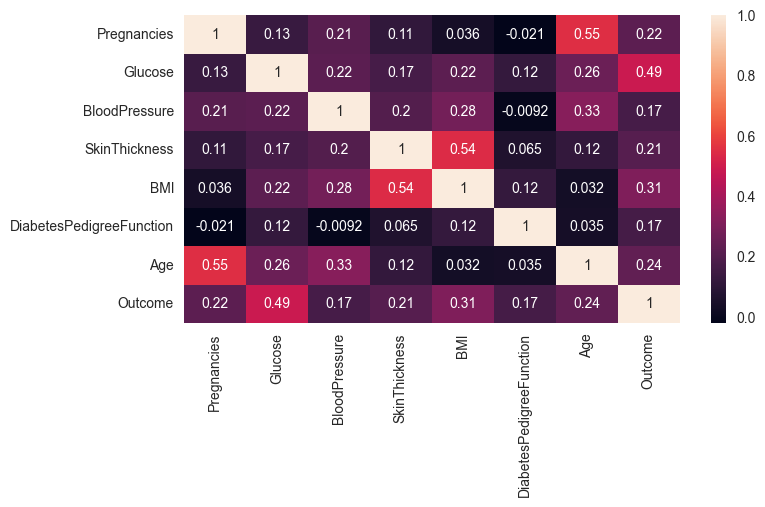

In [12]:
fig, ax=plt.subplots(figsize=(8,4))
sns.heatmap(diabetes_data.corr(), annot=True)

Из строки Outcome видно, что наибольшей корреляцией с целевым признаком обладают факторы Glucose (уровень глюкозы) и BMI (индекс массы тела).

Построим диаграмму рассеяния, по оси абсцисс отложим фактор Glucose, а по оси ординат — BMI. Сделаем цветовую группировку по признаку наличия диабета:

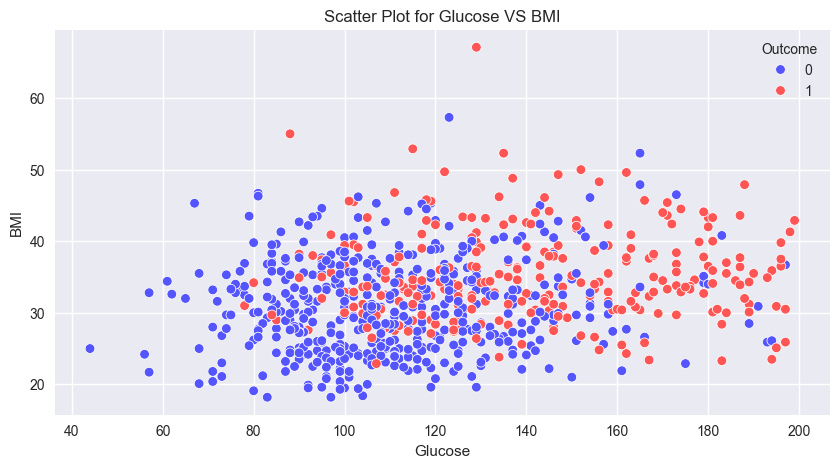

In [13]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=diabetes_data, #датасет
    x='Glucose', #ось абсцисс
    y='BMI', #ось ординат
    hue='Outcome', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);

#Задаём название графику
ax.set_title('Scatter Plot for Glucose VS BMI');

Видно, что классы довольно сильно перемешаны, но красные точки, соответствующие пациентам с диабетом, преимущественно сгруппированы в правой части системы координат.

Давайте попробуем построить разделяющую плоскость с помощью логистической регрессии.

Для начала разделим выборку на матрицу наблюдений X, состоящую из двух признаков, и столбец с правильным ответами y:

In [14]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

Логистическая регрессия — линейная модель, поэтому она находится в уже знакомом нам модуле linear_model из библиотеки sklearn.

In [15]:
from sklearn import linear_model

В модуле находится класс LogisticRegression, который реализует поиск коэффициентов разделяющей плоскости путём минимизации функции потерь logloss различными численными методами.

In [16]:
#Создаём объект класса LogisticRegression
log_reg_2d = linear_model.LogisticRegression(random_state=42)
#Обучаем модель, минимизируя logloss
log_reg_2d.fit(X, y)
#Выводим результирующие коэффициенты
print('w0: {}'.format(log_reg_2d.intercept_)) #свободный член w0
print('w1, w2: {}'.format(log_reg_2d.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: [-8.24901758]
w1, w2: [[0.03779291 0.08757414]]


Как нам сделать предсказание вероятности наличия диабета у пациента?

Мы должны подставить значения факторов в уравнение разделяющей плоскости, а затем результат подставить в функцию сигмоиды. Как хорошо, что для этого есть метод predict_proba().

Например, появился новый пациент с концентрацией глюкозы 180 мг/100мл и индексом массы тела в 51 кг/м2. Мы хотим вычислить вероятность наличия/отсутствия диабета у данного пациента:

In [18]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = pd.DataFrame({'Glucose': [180], 'BMI': [51]})
#Делаем предсказание вероятностей:
y_new_proba_predict = log_reg_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 2)))

Predicted probabilities: [[0.05 0.95]]


Метод predict_proba() возвращает сразу две вероятности: первая соответствует вероятности принадлежности к классу 0 (диабета нет), а вторая — вероятности принадлежности к классу 1 (диабет есть). Заметьте, что в сумме две вероятности дают 1, что вполне логично, так как события взаимоисключающие.

Если мы хотим предсказать не вероятности, а сам класс (1 или 0), нам пригодится метод predict(). По умолчанию метод predict() относит объект к классу 1, если вероятность принадлежности к классу 1 > 0.5, и к классу 0, если эта вероятность < 0.5.

In [19]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = pd.DataFrame({'Glucose': [180], 'BMI': [51]})
#Делаем предсказание класса:
y_new_predict = log_reg_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))

Predicted class: [1]


Предсказанный класс равен 1: значит, модель считает, что данный пациент болеет диабетом.

Теперь построим визуализацию нашей модели.

Чтобы красиво визуализировать вероятности в виде тепловой карты, мы подготовили для вас специальную функцию — plot_probabilities_2d().

Данная функция принимает три аргумента:

X — матрица с наблюдениями,
y — столбец с правильными ответами,
model — модель, с помощью которой делается предсказание вероятностей.

In [20]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

Теперь вызовем нашу функцию и посмотрим, как логистическая вероятность делит пространство на две части.

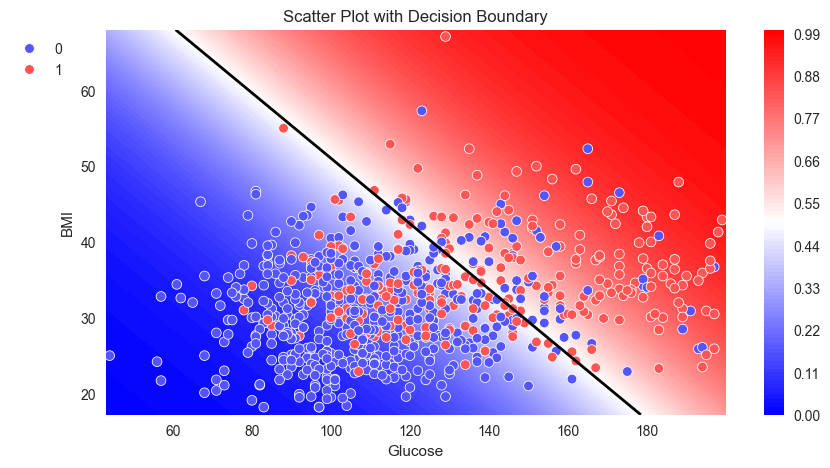

In [21]:
plot_probabilities_2d(X, y, log_reg_2d)

Мы видим разделяющую поверхность (обозначена чёрной линией). Она делит пространство на две части: красное соответствует точкам, которые будут отнесены моделью к классу 1, а синее соответствует точкам, которые будут отнесены моделью к классу 0.

Справа от графика есть цветовая панель, которая показывает значение вероятности того, что пациент болен диабетом (по мнению модели).

Обратите внимание, что чем более точка удалена от разделяющей плоскости, тем с большей вероятностью модель относит её к тому или иному классу. На тепловой карте это прослеживается в интенсивности синего и красного цвета.

Из графика видно, что довольно много синих точек попали в красную зону и наоборот. Видимо, информации о двух факторах всё же маловато для того, чтобы хорошо провести классификацию.

Давайте будем использовать для построения модели всю предоставленную нам информацию — все факторы из набора данных. Для этого заново создадим матрицу наблюдений X и вектор ответов y:

In [22]:
#Создаём матрицу признаков X и столбец с ответами y
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

Затем обучим модель логистической регрессии с помощью метода fit().

Сделаем предсказание вероятности заболевания диабетом для каждого пациента и самих классов с помощью методов predict_proba() и predict().



In [23]:
#Создаём объект класса LogisticRegression
log_reg_full = linear_model.LogisticRegression(random_state=42, max_iter=1000)
#Обучаем модель, минимизируя logloss
log_reg_full.fit(X, y)
#Делаем предсказание класса
y_pred = log_reg_full.predict(X)

Затем добавим предсказание в таблицу X для наглядности:

In [24]:
#Создадим временную таблицу X
X_temp = X.copy()
#Добавим в эту таблицу результат предсказания
X_temp['Prediction'] = y_pred
X_temp.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Prediction
752,5,139.0,64.0,35.0,28.6,0.411,26,0
753,1,96.0,122.0,29.0,22.4,0.207,27,0
754,10,101.0,86.0,37.0,45.6,1.136,38,1
755,0,141.0,72.0,29.0,42.4,0.205,29,1
756,0,125.0,96.0,29.0,22.5,0.262,21,0


Итак, мы сделали предсказание для каждого наблюдения (пациента) из таблицы X.

К сожалению, теперь, когда признаков больше двух, построить красивую визуализацию разделяющей плоскости не получится.

→ Но как же тогда узнать, насколько хорошо модель определяет наличие диабета у пациента? Для этого используются метрики классификации, о которых мы поговорим в следующем юните.

### Практика

#### Задание 2.9

Таблица состоит из четырёх столбцов:

- SNo — номер строки (данный столбец вам не понадобится, вы можете сразу его удалить);
- X_1 и X_2 — факторы;
- y — целевой признак.

Обучите модель логистической регрессии для предсказания целевого признака y. В качестве алгоритма оптимизации используйте стохастический градиентный спуск (масштабировать данные не нужно). В качестве значения параметра random_state возьмите число 42, остальные параметры оставьте по умолчанию.

Воспользуйтесь функцией plot_probabilities_2d(), которую мы объявили ранее. Постройте визуализацию разделяющей поверхности.

Сколько объектов класса 0 будут неверно отнесены моделью к классу 1?

In [25]:
task_data=pd.read_csv('data/task_data.csv')
task_data.head(5)

,SNo,X_1,X_2,y
0,0,-0.869144,0.389310,0.0
1,1,-0.993467,-0.610591,0.0
2,2,-0.834064,0.239236,0.0
3,3,-0.136471,0.632003,1.0
4,4,0.403887,0.310784,1.0


In [27]:
task_data.drop(columns='SNo', inplace=True)
task_data.head(5)

,X_1,X_2,y
0,-0.869144,0.389310,0.0
1,-0.993467,-0.610591,0.0
2,-0.834064,0.239236,0.0
3,-0.136471,0.632003,1.0
4,0.403887,0.310784,1.0


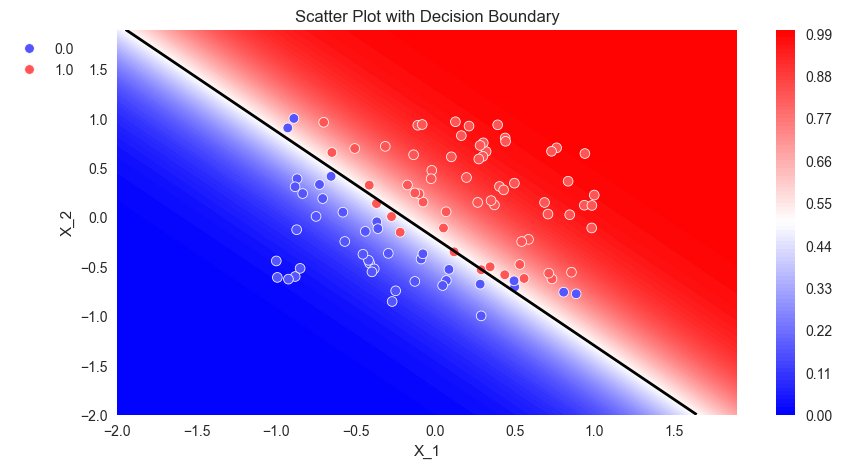

In [28]:
X = task_data[['X_1', 'X_2']]
y = task_data['y']

log_reg = linear_model.LogisticRegression(solver='sag', random_state=42)
log_reg.fit(X, y)

plot_probabilities_2d(X, y, log_reg)